# Stationarity of the processes

In [28]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [29]:
import plotly.io as pio

pio.templates.default = "plotly_dark"

In [30]:
df = pd.read_csv('games.csv')

In [31]:
## data pre-processing ##

df.columns = df.columns.str.lower()

# Удаляем отсутствующие значения столбца year_of_release. Восстанавлявать столь малый процент (1.61) не имеет смысла.
df = df.dropna(subset=['year_of_release'])
df['year_of_release'] = df['year_of_release'].astype(np.int64)

# По тем же причинам удаляем строки с отсутвием названия игры
df = df.dropna(subset=['name'])

df.loc[df['user_score'] == 'tbd', 'user_score'] = 'unknown'
df = df.fillna('unknown')

df = df.query('user_score != "unknown"')
df['user_score'] = df['user_score'].map(float) # astype(float)

df['world_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

## Step 1. Choose about 3-6 variables from your dataset (2-3 – target variables, the rest - predictors).

In [32]:
targets = ['user_score', 'na_sales', 'other_sales']

In [33]:
predictors = df[[
    'name', 'platform', 'year_of_release', 'eu_sales',
    'jp_sales', 'critic_score', 'world_sales',
    'genre', 'rating'
]]

## Step 2. Analyze stationarity of a process (for mathematical expectation and variance) for all chosen variables. Make them more stationary if needed.

###  Make them more stationary if needed.

In [34]:
from statsmodels.tsa.stattools import adfuller

def isStationarity(feature, data=df):
    test = adfuller(data[[feature]])

    print(f'\nFor "{feature}":')

    print(f"adf {test[0]}")
    print(f"p-value {test[1]}")
    print(f"critical values {test[4]}")

    if test[0] > test[4]["5%"]:
        print(f"Non-Stationarity")
    else:
        print("Stationarity")

In [35]:
for num in targets:
    isStationarity(num)


For "user_score":
adf -9.655273340704182
p-value 1.3995786123067034e-16
critical values {'1%': -3.4312308997948735, '5%': -2.861929290450442, '10%': -2.5669772149563093}
Stationarity

For "na_sales":
adf -11.112632812308433
p-value 3.627962213252247e-20
critical values {'1%': -3.431230781146087, '5%': -2.8619292380245076, '10%': -2.5669771870492286}
Stationarity

For "other_sales":
adf -11.727480260876677
p-value 1.3665971615417534e-21
critical values {'1%': -3.4312308997948735, '5%': -2.861929290450442, '10%': -2.5669772149563093}
Stationarity


## Step 3. Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets.

In [36]:
from statsmodels.tsa import stattools
from matplotlib import pyplot as plt
variable = [df["user_score"],df["na_sales"],df["other_sales"]]

# https://colab.research.google.com/drive/1PcBwAvA8KHIWGjNjYqK37rG6lN0547xu#scrollTo=wmYdCQfRisRp

# plt.plot(stattools.acovf(variable,fft=False)) #autocovariance without window
for t in variable:
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=stattools.acovf(t,fft=False), fill='tozeroy',
                        mode='markers+lines' # override default markers+lines
                        ))

    fig.show()

In [37]:
preds = [df['world_sales'],df['year_of_release']]
# variable = [df["user_score"],df["na_sales"],df["other_sales"]]
for i in variable:
    for j in preds:        
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=stattools.ccf(i, j, adjusted=False), fill='tozeroy',
                            mode='markers+lines' # override default markers+lines
                            ))

        fig.show()

## Step 4. Filter high frequencies (noise) with chosen 2 filters for target variables.

In [38]:

# filtering with rolling mean
for target in targets:
    df['rol_mean'] = df[[target]].rolling(50).mean()
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(y=df[target],
                    name='Original data', line_color='#043C6B'))
    fig.add_trace(go.Scatter(y=df['rol_mean'],
                    name='Filtered data', line_color='#FFF'))
    
    fig.update_layout(xaxis_range=[-0.32,5000], template='plotly_dark')

    fig.show()

In [39]:
# filtering with signal.filtfilt
from scipy import signal

fs = 700 # sampling frequency
fc = 30  # cut frequency
w = fc / (fs / 2) # normalisation

for target in targets:
    b, a = signal.butter(5, w)
    df["output_btw"] = signal.filtfilt(b, a, df[[target]], axis=0)

    fig = go.Figure()

    fig.add_trace(go.Scatter(y=df[target],
                    name='Original data', line_color='#043C6B'))
    fig.add_trace(go.Scatter(y=df["output_btw"],
                    name='Filtered data', line_color='#FFF'))
    
    fig.update_layout(xaxis_range=[-0.32,5000])
    
    fig.show()

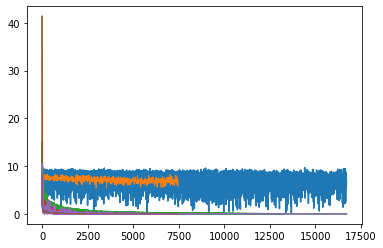

In [40]:
from scipy import signal

fs = 700 # sampling frequency
fc = 30  # cut frequency
w = fc / (fs / 2) # normalisation

for target in targets:
    b, a = signal.butter(5, w)
    output_btw = signal.filtfilt(b, a, df[[target]], axis=0)
    # plt.figure(figsize=(10, 8))
    plt.plot(df[[target]])
#   rol_mean = df[[target]].rolling(10).mean()
#   plt.plot(rol_mean)
    plt.plot(output_btw, linewidth=1)
    

## Step 5. Estimate spectral density function for with and without filtering.

In [43]:
window_size = 72
blackman = signal.blackman(M=window_size)

## Step 6. Built auto-regression model filtered and non-filtered data. To analyze residual error and to define appropriate order of model.

In [45]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [57]:
df_ml = df.query('critic_score != "unknown"').copy()
df_ml['critic_score'] = df_ml['critic_score'].astype('int')
df_ml['user_score'] = df_ml['user_score'].astype('int')
# df_ml['na_sales'] = df_ml['na_sales'].astype('int')


# df_ml = df_ml[['year_of_release', 'user_score', 'critic_score', 'genre', 'na_sales']]

df_ml = df_ml[['year_of_release', 'user_score', 'critic_score', 'na_sales']]


# df_ml = pd.get_dummies(df_ml)

df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6894 entries, 0 to 16705
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year_of_release  6894 non-null   int64  
 1   user_score       6894 non-null   int64  
 2   critic_score     6894 non-null   int64  
 3   na_sales         6894 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 269.3 KB


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_ml.drop(columns='na_sales')
y = df_ml['na_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [59]:
"""
YES
"""

training_data = df_ml.sample(frac=0.8, random_state=25)
testing_data = df_ml.drop(training_data.index)

In [35]:
!pip install pmdarima

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [66]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

In [63]:
# data = df_ml[['year_of_release', 'na_sales']].copy().set_index('year_of_release')
data = df_ml[['year_of_release', 'na_sales']].groupby('year_of_release').agg('sum')

data # http://alkaline-ml.com/pmdarima/auto_examples/arima/example_auto_arima.html#sphx-glr-auto-examples-arima-example-auto-arima-py

na_sales 
 
 
 year_of_release 
 
 
 
 
 
 1985 
 0.00 
 
 
 1988 
 0.00 
 
 
 1992 
 0.02 
 
 
 1994 
 0.39 
 
 
 1996 
 8.05 
 
 
 1997 
 15.46 
 
 
 1998 
 18.81 
 
 
 1999 
 23.32 
 
 
 2000 
 39.34 
 
 
 2001 
 139.32 
 
 
 2002 
 163.76 
 
 
 2003 
 143.30 
 
 
 2004 
 173.88 
 
 
 2005 
 178.15 
 
 
 2006 
 225.69 
 
 
 2007 
 235.61 
 
 
 2008 
 256.48 
 
 
 2009 
 231.72 
 
 
 2010 
 213.24 
 
 
 2011 
 190.82 
 
 
 2012 
 133.94 
 
 
 2013 
 121.20 
 
 
 2014 
 79.38 
 
 
 2015 
 68.26 
 
 
 2016 
 34.86

Test RMSE: 151.818


/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Text(0.5, 0, 'year_of_release')

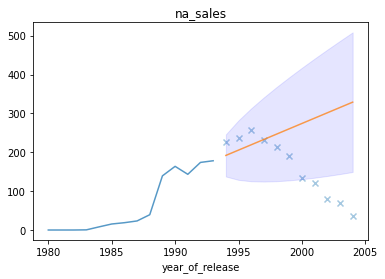

In [67]:
# import ÷ as pm
# from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# #############################################################################
# Load the data and split it into separate pieces
# fig.set_size_inches(14,2)

data = df_ml[['year_of_release', 'na_sales']].groupby('year_of_release').agg('sum')

train, test = model_selection.train_test_split(data, train_size=14)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1980  # Year starts at 1980

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[train.shape[0]:]], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("na_sales")
plt.xlabel("year_of_release")

Test RMSE: 0.433


/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Text(0.5, 0, 'year_of_release')

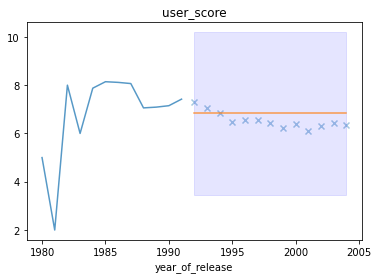

In [68]:
data = df_ml[['year_of_release', 'user_score']].groupby('year_of_release').agg('mean')

train, test = model_selection.train_test_split(data, train_size=12)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis + 1980  # Year starts at 1980

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[train.shape[0]:]], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("user_score")
plt.xlabel("year_of_release")

## Step 7. Build model in a form of linear dynamical system, using chosen predictors. To analyze residual error and to define appropriate order of model.

In [73]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [69]:
test_size = 15

train, test = df_ml[['year_of_release', 'na_sales']][:-test_size], df_ml[['year_of_release', 'na_sales']][-test_size:]

# https://www.statsmodels.org/dev/vector_ar.html

history = train
predictions = list()

# for t in range(test.shape[0]):
#     model = VAR(endog=history)
#     model_fit = model.fit(maxlags=16)
#     print(model_fit.summary())
#     model_fit.plot_acorr()
#     # output = model_fit.forecast(model_fit.y, steps=1)
#     # yhat = output[0]
#     # predictions.append(y)
#     # obs = test.iloc[t]
#     # history = history.append(obs)

# history

/opt/python/envs/default/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



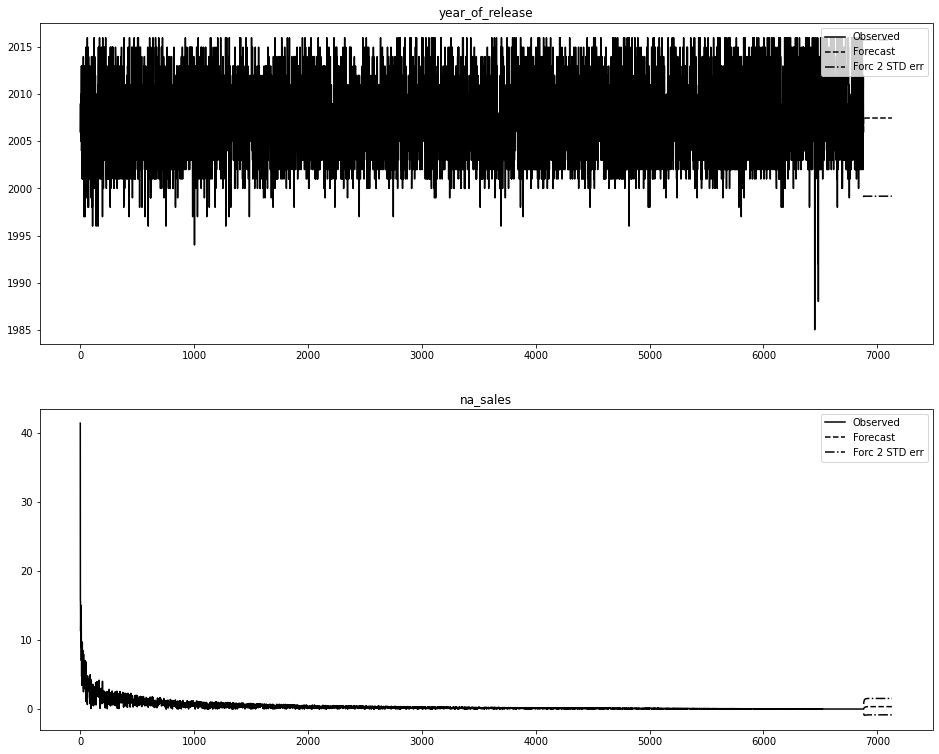

In [74]:
# plt.rcParams["figure.figsize"] = (22, 22)
model = VAR(train)

results = model.fit(2)

fig = results.plot_forecast(250)
fig.set_size_inches(16,13)

In [75]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 08, Dec, 2022
Time:                     16:13:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.794655
Nobs:                     6877.00    HQIC:                  0.788143
Log likelihood:          -22204.3    FPE:                    2.19178
AIC:                     0.784715    Det(Omega_mle):         2.18860
--------------------------------------------------------------------
Results for equation year_of_release
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                   1957.637373        34.088073           57.429           0.000
L1.year_of_release         0.008725         0.012076            0.722           0.470
L1.na_sales               -0.0